In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rc  ### 이 줄
# import scienceplots

plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결

from datetime import datetime

# import warnings
# warnings.filterwarnings("ignore")

# plt.style.use('seaborn-deep')
# plt.style.use(['science'])
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

%matplotlib inline

In [2]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

In [3]:
from sdv.single_table import TVAESynthesizer

synthesizer = TVAESynthesizer.load(
    filepath='model/trained_disaster_1024.pkl'
)

In [7]:
synthetic_data = synthesizer.sample(num_rows=18000) # 200000
synthetic_data

,tweet_id,text_info,text_info_conf,text_human,text_human_conf,tweet_text,category
0,874566235481994240,not_informative,1.0000,not_humanitarian,1.0000,I just had to evacuate my home in California d...,flood
1,910154876765076736,informative,0.3498,affected_individuals,0.3477,While SFWMD's EOC remains activated to focus o...,hurricane
2,904920903114737280,informative,0.7621,other_relevant_information,0.7587,RT @KleinISD: Hurricane Harvey Update from Kle...,hurricane
3,912214248521394432,informative,0.6893,rescue_volunteering_or_donation_effort,0.6887,"CONGRATS ON HITTING YOIR GOAL GUYS, I'm sure t...",hurricane
4,903403759536161152,informative,0.6532,other_relevant_information,0.6652,Please join us in prayer for first responders ...,hurricane
...,...,...,...,...,...,...,...
17995,911843112086447872,informative,0.6949,other_relevant_information,0.6849,"CONGRATS ON HITTING YOIR GOAL GUYS, I'm sure t...",hurricane
17996,909497520506128896,not_informative,1.0000,not_humanitarian,0.9999,"RT @femaregion4: #FL, don't wait to clean up s...",hurricane
17997,930419339730254208,informative,0.6528,rescue_volunteering_or_donation_effort,0.6518,Despair as death toll jumps after massive #Ira...,earthquake
17998,911397006959833728,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,RT @democracynow: Mexico: Earthquake Death Tol...,earthquake


In [9]:
metadata.detect_from_dataframe(data=synthetic_data)
metadata

{
    "columns": {
        "tweet_id": {
            "sdtype": "numerical"
        },
        "text_info": {
            "sdtype": "categorical"
        },
        "text_info_conf": {
            "sdtype": "numerical"
        },
        "text_human": {
            "sdtype": "categorical"
        },
        "text_human_conf": {
            "sdtype": "numerical"
        },
        "tweet_text": {
            "sdtype": "categorical"
        },
        "category": {
            "sdtype": "categorical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [10]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         18000 non-null  int64  
 1   text_info        18000 non-null  object 
 2   text_info_conf   18000 non-null  float64
 3   text_human       18000 non-null  object 
 4   text_human_conf  18000 non-null  float64
 5   tweet_text       18000 non-null  object 
 6   category         18000 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 984.5+ KB


/var/folders/b9/8j1qkty17r9244bwmgfs9kdc0000gn/T/ipykernel_50021/1093002169.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


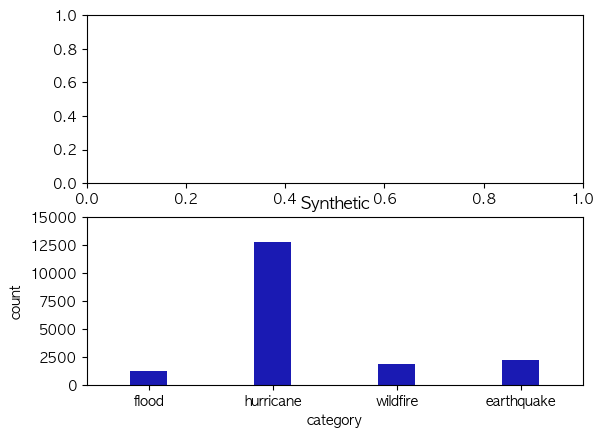

In [11]:
import seaborn as sns

fig, ax =plt.subplots(2,1)
# sns.countplot(data=df_final, x='category', ax=ax[0], color='#0000CD', width=0.3).set_title('Real')
sns.countplot(data=synthetic_data, x='category', ax=ax[1], color='#0000CD', width=0.3).set_title('Synthetic')

fig.show()

In [12]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [13]:
synthetic_data['tweet_text']

0        I just had to evacuate my home in California d...
1        While SFWMD's EOC remains activated to focus o...
2        RT @KleinISD: Hurricane Harvey Update from Kle...
3        CONGRATS ON HITTING YOIR GOAL GUYS, I'm sure t...
4        Please join us in prayer for first responders ...
                               ...                        
17995    CONGRATS ON HITTING YOIR GOAL GUYS, I'm sure t...
17996    RT @femaregion4: #FL, don't wait to clean up s...
17997    Despair as death toll jumps after massive #Ira...
17998    RT @democracynow: Mexico: Earthquake Death Tol...
17999    I'm at RsN Ing. Planta industrial in Fernando ...
Name: tweet_text, Length: 18000, dtype: object

In [14]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
synthetic_data['tweet_text'] = synthetic_data['tweet_text'].apply(clean_text)
synthetic_data['tweet_text']

/var/folders/b9/8j1qkty17r9244bwmgfs9kdc0000gn/T/ipykernel_50021/905062806.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding


0        evacuate home california due wildfire obviousl...
1        sfwmds eoc remains activated focus #irma recov...
2        rt kleinisd hurricane harvey update klein isd ...
3        congrats hitting yoir goal guys im sure victim...
4        please join us prayer first responders impacte...
                               ...                        
17995    congrats hitting yoir goal guys im sure victim...
17996    rt femaregion4 #fl dont wait clean storm damag...
17997    despair death toll jumps massive #iran quake h...
17998    rt democracynow mexico earthquake death toll 2...
17999    im rsn ing planta industrial fernando de la mo...
Name: tweet_text, Length: 18000, dtype: object

In [15]:
synthetic_data['tweet_text'].apply(lambda x: len(x.split(' '))).sum()

245662

In [17]:
X = synthetic_data.tweet_text
y = synthetic_data.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
my_tags=['hurricane', 'wildfire', 'earthquake', 'flood']

In [18]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7570370370370371
              precision    recall  f1-score   support

   hurricane       0.84      0.21      0.33       670
    wildfire       0.85      0.19      0.31       349
  earthquake       0.75      0.99      0.86      3829
       flood       0.80      0.15      0.26       552

    accuracy                           0.76      5400
   macro avg       0.81      0.39      0.44      5400
weighted avg       0.77      0.76      0.69      5400

CPU times: user 191 ms, sys: 16.2 ms, total: 207 ms
Wall time: 214 ms
